0. <u>Imports and downloads</u>

In [ ]:
#!pip install google-cloud-storage

In [ ]:
# Import
import pickle

# Visualisation
import matplotlib.pyplot as plt

# Modelling
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.callbacks import Callback

# Cloud
from google.colab import auth
from google.cloud import storage

# File management
import os
import tempfile

In [ ]:
# Cloud authentification

auth.authenticate_user()
client = storage.Client()
bucket = client.get_bucket('piano-trancript')

In [ ]:
# Functions to manage file operations with GCS. They will be used to save the model and load the dataset.

def upload_file_to_bucket(local_file_path, blob_name):
    """
    Uploads a file to GCS.
    """
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(local_file_path)


def load_pkl_from_gcp(source_blob):
    """
    Download a .pkl file stored in GCS.
    """

    blob = bucket.blob(source_blob)
    pkl_data = blob.download_as_string()
    data_list = pickle.loads(pkl_data)

    print(f"File {source_blob} loaded from GCS.")
    return data_list

*2*. <u>Create X and y</u>

A. Train and test sets

In [ ]:
# Upload X and y

X = load_pkl_from_gcp('dataset/X')
y = load_pkl_from_gcp('dataset/y')

File dataset/X loaded from GCS.
File dataset/y loaded from GCS.


In [ ]:
# Split X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

3. <u>Modelling</u>

In [ ]:
# Callback definition

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 8,
    restore_best_weights = True
)

In [ ]:
# Compiling & fitting parameters

epochs = 100
batch_size = 32
initial_learning_rate = .00001
img_size = (60, 150)

# Learning rate decay definition

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps = 500,
    decay_rate = 0.9,
    staircase = True
)

# Model architecture

model = Sequential()
model.add(Conv2D(32, kernel_size = (5,5), strides = (1,1),activation = 'tanh', input_shape = (img_size[0], img_size[1], 1)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Conv2D(64, (3,3), activation = 'tanh'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(88, activation = 'sigmoid')) # Multi-label classification (switch to softmax if you want to predict one note at a time)

# Compiling

model.compile(
    loss = losses.binary_crossentropy, # multi-label classification (switch to losses.categorical_crossentropy if you want to predict one note at a time)
    optimizer=optimizers.Adam(learning_rate = lr_schedule),
    metrics = [
        'accuracy',
        'precision'
        ]
    )

# Fitting

history = model.fit(
    X_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = 0.2,
    #callbacks = [early_stop],
    verbose = 1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.0039 - loss: 0.4284 - precision: 0.0467 - val_accuracy: 0.0036 - val_loss: 0.1397 - val_precision: 0.0000e+00
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0069 - loss: 0.1350 - precision: 0.0000e+00 - val_accuracy: 0.0065 - val_loss: 0.1246 - val_precision: 0.0000e+00
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0074 - loss: 0.1242 - precision: 0.0000e+00 - val_accuracy: 0.0089 - val_loss: 0.1186 - val_precision: 0.0000e+00
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0103 - loss: 0.1180 - precision: 0.6132 - val_accuracy: 0.0095 - val_loss: 0.1136 - val_precision: 1.0000
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0126 - loss: 0.1128 - precision: 0.9825 - val_accuracy: 0.0119 - val_loss: 0.1091 - val_precision: 0.8804
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0147 - loss: 0.1082 - precision: 0.9683 - val_

In [ ]:
# Results on test set

results = model.evaluate(X_test, y_test, verbose = 0)
print(f'The accuracy on the test set is of {results[1]:.2f}')

The accuracy on the test set is of 0.96


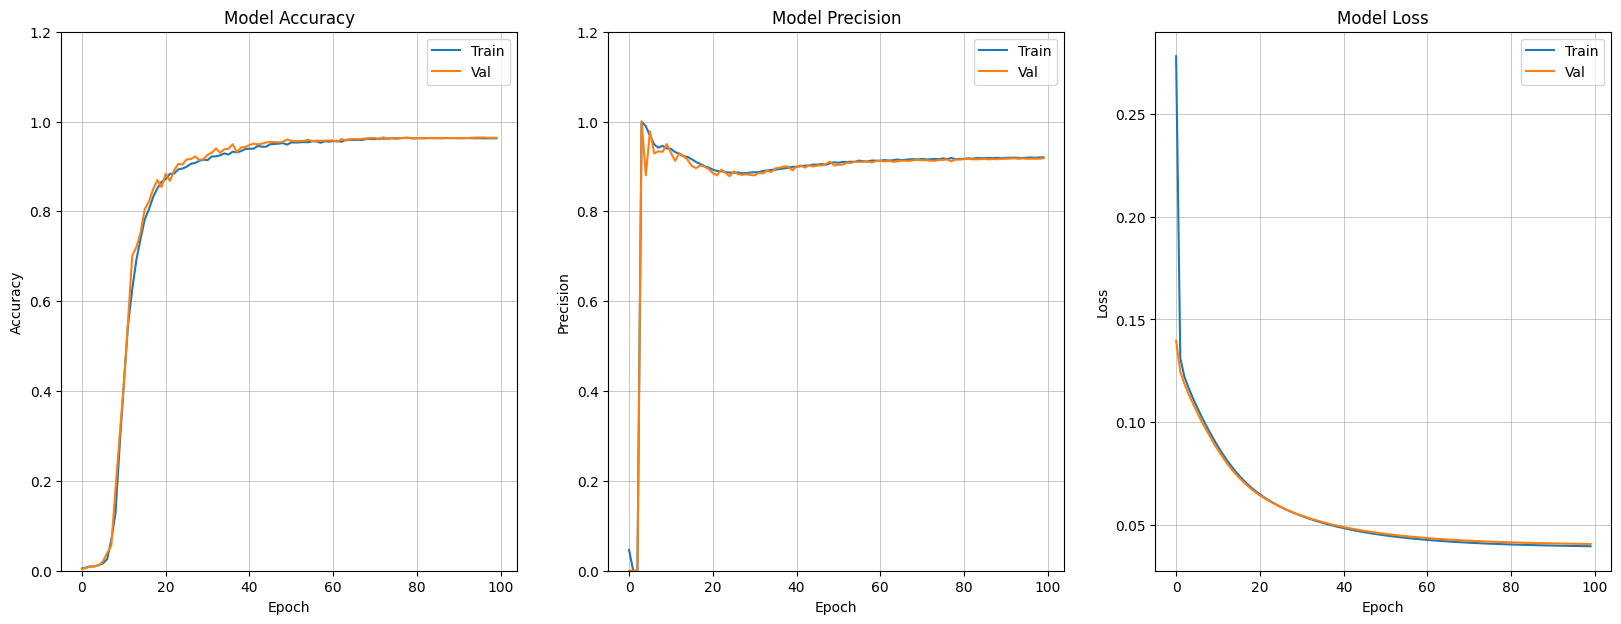

In [ ]:
def plot_loss_accuracy(history):
    fig, axs = plt.subplots(1, 3, figsize=(20, 7))

    # Plot accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='best')
    axs[0].set_ylim((0, 1.2))
    axs[0].grid(axis="x", linewidth=0.5)
    axs[0].grid(axis="y", linewidth=0.5)

    # Plot precision
    axs[1].plot(history.history['precision'])
    axs[1].plot(history.history['val_precision'])
    axs[1].set_title('Model Precision')
    axs[1].set_ylabel('Precision')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='best')
    axs[1].set_ylim((0, 1.2))
    axs[1].grid(axis="x", linewidth=0.5)
    axs[1].grid(axis="y", linewidth=0.5)

    # Plot loss
    axs[2].plot(history.history['loss'])
    axs[2].plot(history.history['val_loss'])
    axs[2].set_title('Model Loss')
    axs[2].set_ylabel('Loss')
    axs[2].set_xlabel('Epoch')
    axs[2].legend(['Train', 'Val'], loc='best')
    axs[2].grid(axis="x", linewidth=0.5)
    axs[2].grid(axis="y", linewidth=0.5)

    plt.show()

plot_loss_accuracy(history)

In [ ]:
model.save('model/model.keras')

In [ ]:
upload_file_to_bucket('model/model.keras','model/model.keras')